### Import relevant libraries

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats.mstats import gmean

In [2]:
price_df = pd.read_csv('../Data/prices_cleaned.csv')
sec_df = pd.read_csv('../Data/securities_cleaned.csv')

### Read csv files as Pandas dataframes

In [3]:
price_df.head()

date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0

In [4]:
sec_df.head()

symbol             Security SEC filings                  sector  \
0    MMM           3M Company     reports             Industrials   
1    ABT  Abbott Laboratories     reports             Health Care   
2   ABBV               AbbVie     reports             Health Care   
3    ACN        Accenture plc     reports  Information Technology   
4   ATVI  Activision Blizzard     reports  Information Technology   

                GICS Sub Industry   Address of Headquarters      CIK  
0        Industrial Conglomerates       St. Paul, Minnesota    66740  
1           Health Care Equipment   North Chicago, Illinois     1800  
2                 Pharmaceuticals   North Chicago, Illinois  1551152  
3  IT Consulting & Other Services           Dublin, Ireland  1467373  
4     Home Entertainment Software  Santa Monica, California   718877

Text(0.5, 1.0, 'Number of S&P 500 companies by Sector')

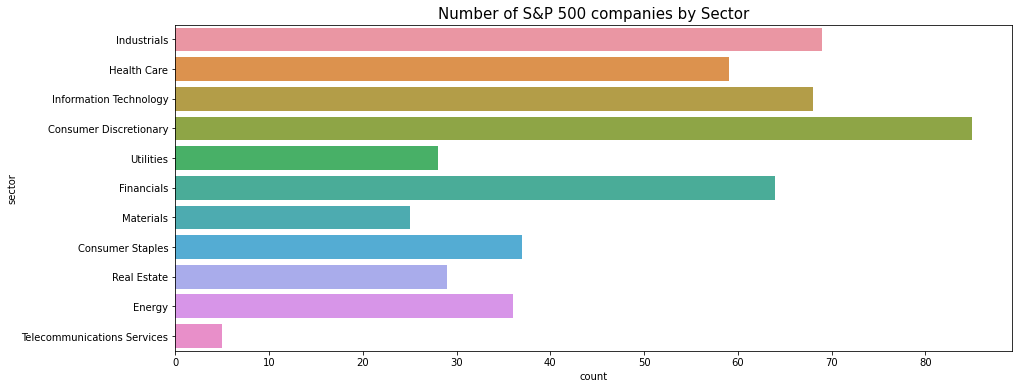

In [5]:
plt.figure(figsize=(15, 6))
sns.countplot(y='sector', data=sec_df)
plt.title('Number of S&P 500 companies by Sector', fontsize=15)

### Correlation matrix of sectors (average price movement)

#### For simplicity we will only analyze the stock prices from the year of 2016.

In [6]:
price_df = price_df[price_df['date'] >= '2016-01-01']

#### Merge the sector column into the price dataframe

In [7]:
price_df  = price_df.merge(sec_df[['symbol','sector']], on = 'symbol')
price_df['date'] = pd.to_datetime(price_df['date'])
price_df.head()

date symbol        open       close         low        high  \
0 2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1 2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2 2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3 2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4 2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume      sector  
0  2163600.0  Financials  
1  2386400.0  Financials  
2  2489500.0  Financials  
3  2006300.0  Financials  
4  1408600.0  Financials

#### Create a heatmap of correlation matrix 

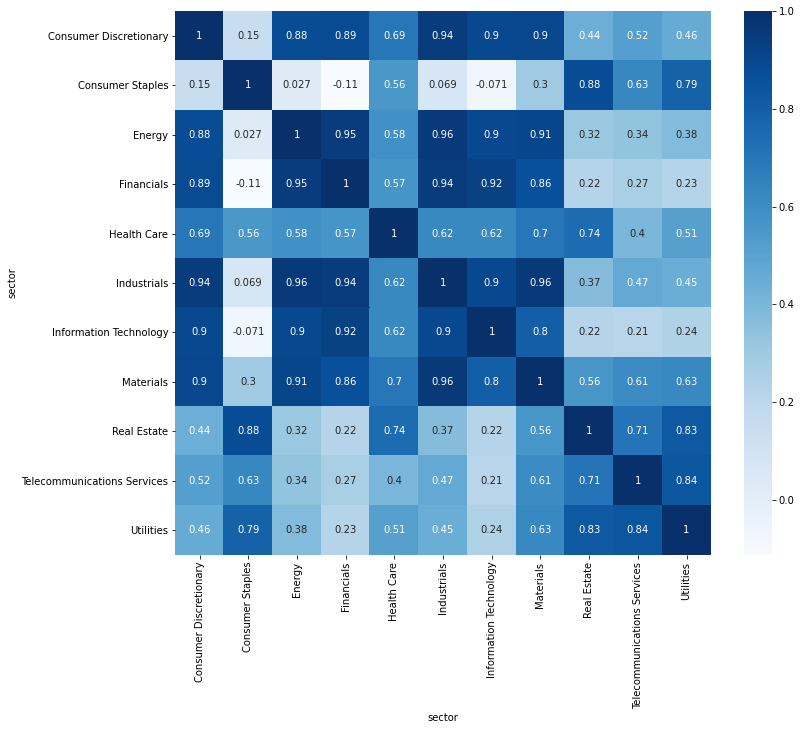

In [12]:
sector_pivot = pd.pivot_table(price_df, values='close', index=['date'], columns=['sector']).reset_index()

plt.figure(figsize = (12,10))
sns.heatmap(sector_pivot.corr(),annot=True, cmap="Blues")

#### Calculate daily return for each security (drop the first days with NaNs)

In [13]:
price_df['return'] = np.log(price_df.close / price_df.close.shift(1)) + 1
price_df['good'] = price_df['symbol'] == price_df['symbol'].shift(1)
price_df = price_df.drop(price_df[price_df['good'] == False].index)
price_df.dropna(inplace = True)

In [15]:
price_df.head()

date symbol        open       close         low        high  \
1 2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2 2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3 2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4 2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   
5 2016-01-12   WLTW  115.510002  115.550003  114.500000  116.059998   

      volume      sector    return  good  
1  2386400.0  Financials  0.952314  True  
2  2489500.0  Financials  0.957172  True  
3  2006300.0  Financials  1.014424  True  
4  1408600.0  Financials  0.985750  True  
5  1098000.0  Financials  1.005032  True

### Portfolio selection by sector

#### Calculate sharpe ratio for each sector by subtracting risk-free rate (10-year treasury yield) from average annual return, then dividing by standard deviation of daily returns

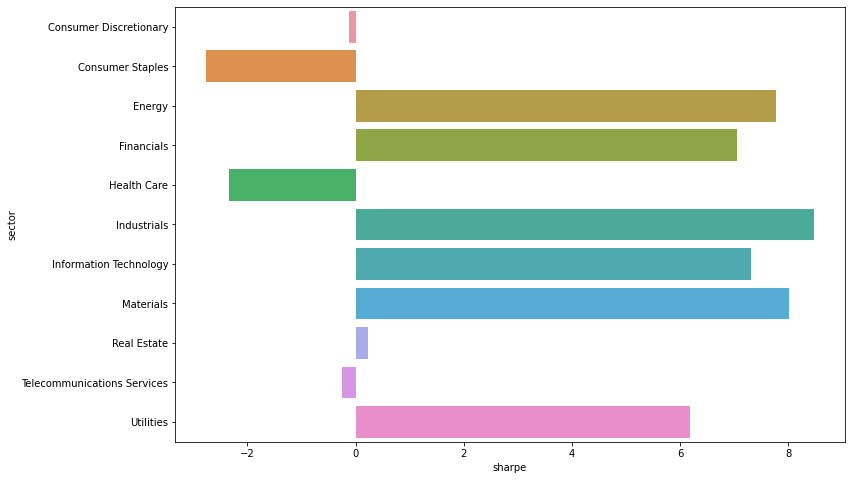

In [16]:
risk_free = 0.032

sector_df = pd.DataFrame({'return' : (price_df.groupby('sector')['return'].mean() - 1) * 252, 'stdev' : price_df.groupby('sector')['return'].std()})
sector_df['sharpe'] = (sector_df['return'] - risk_free) / sector_df['stdev']

plt.figure(figsize = (12,8))
ax = sns.barplot(x= sector_df['sharpe'], y = sector_df.index)

#### Only select the sectors that have sharpe ratio higher than 1

In [17]:
port_list = sector_df[sector_df['sharpe'] >= 1].index
port_list

Index(['Energy', 'Financials', 'Industrials', 'Information Technology',
       'Materials', 'Utilities'],
      dtype='object', name='sector')

#### Pick the highest returning stock in each sector

In [21]:
port_stock = []
return_stock = []
def get_stock(sector):
    list_stocks = price_df[price_df['sector'] == sector]['symbol'].unique()
    performance = price_df.groupby('symbol')['return'].apply(lambda x : (gmean(x) - 1) * 252).sort_values(ascending = False)
    
    for i in range(len(performance)):
        if performance.index[i] in list_stocks:
            port_stock.append(performance.index[i])
            return_stock.append(performance[i])
            break
    
for sector in port_list:
    get_stock(sector)

highest_return_stocks = list(zip(port_stock, return_stock))
highest_return_stocks

[('OKE', 0.7173652956838588),
 ('CMA', 0.44551901957171847),
 ('PWR', 0.5035533860026078),
 ('NVDA', 1.1050398271015816),
 ('NEM', 0.49897417362066854),
 ('CNP', 0.278381698774802)]

In [22]:
port_df = price_df[price_df['symbol'].isin(port_stock)].pivot('date','symbol','return')

In [23]:
port_df

symbol           CMA       CNP       NEM      NVDA       OKE       PWR
date                                                                  
2016-01-05  0.989079  1.009262  0.998915  1.015937  1.000789  0.957248
2016-01-06  0.988465  0.987449  1.007572  0.957771  0.953611  0.998972
2016-01-07  0.979550  0.980033  1.016035  0.959548  0.938704  0.972887
2016-01-08  0.982462  0.997757  0.953884  0.978300  1.011783  0.988304
2016-01-11  0.993569  0.988139  0.942874  1.001686  0.980727  0.987624
...              ...       ...       ...       ...       ...       ...
2016-12-23  1.003327  0.999597  1.031928  1.024622  1.013379  1.003165
2016-12-27  1.004898  0.997177  1.003997  1.066427  1.005776  1.006586
2016-12-28  0.986109  0.986992  1.005813  0.928734  0.976691  0.982147
2016-12-29  0.989601  1.011796  1.073214  1.019758  1.005361  1.004927
2016-12-30  1.002794  0.996354  0.965384  0.956999  0.990120  1.007488

[251 rows x 6 columns]

### Porfolio risk and return calculation

#### Randomly assign weights to the six stocks (must add up to 1), then calculate portfolio return, stdev, and sharpe ratio.  Simulate 2000 times. 

In [27]:
return_pred = []
weight_pred = []
std_pred = []
for i in range(2000):
    random_matrix = np.array(np.random.dirichlet(np.ones(len(port_stock)),size=1)[0])
    port_std = np.sqrt(np.dot(random_matrix.T, np.dot(port_df.cov(),random_matrix))) * np.sqrt(252)
    port_return = np.dot(return_stock, random_matrix)
    return_pred.append(port_return)
    std_pred.append(port_std)
    weight_pred.append(random_matrix)

In [28]:
pred_output = pd.DataFrame({'weight' : weight_pred , 'return' : return_pred, 'stdev' :std_pred })
pred_output['sharpe'] = (pred_output['return'] - risk_free) / pred_output['stdev']
pred_output.head()

weight    return     stdev  \
0  [0.11579959460850545, 0.28114160479559813, 0.2...  0.516679  0.219303   
1  [0.41308282537217794, 0.04411126699839337, 0.3...  0.588226  0.246479   
2  [0.3370081662123746, 0.31624133329393245, 0.01...  0.683788  0.213550   
3  [0.16351922889271991, 0.04548403568622971, 0.2...  0.630607  0.220476   
4  [0.2465903630130944, 0.08668540444696003, 0.06...  0.493896  0.243809   

     sharpe  
0  2.287605  
1  2.325658  
2  3.131764  
3  2.792170  
4  1.964227

#### Plot all 2000 return and volatility (stdev) combinations, then find the two points with the highest sharpe ratio, and the lowest volatility

In [29]:
max_pos = pred_output.iloc[pred_output.sharpe.idxmax(),:]
safe_pos = pred_output.iloc[pred_output.stdev.idxmin(),:]

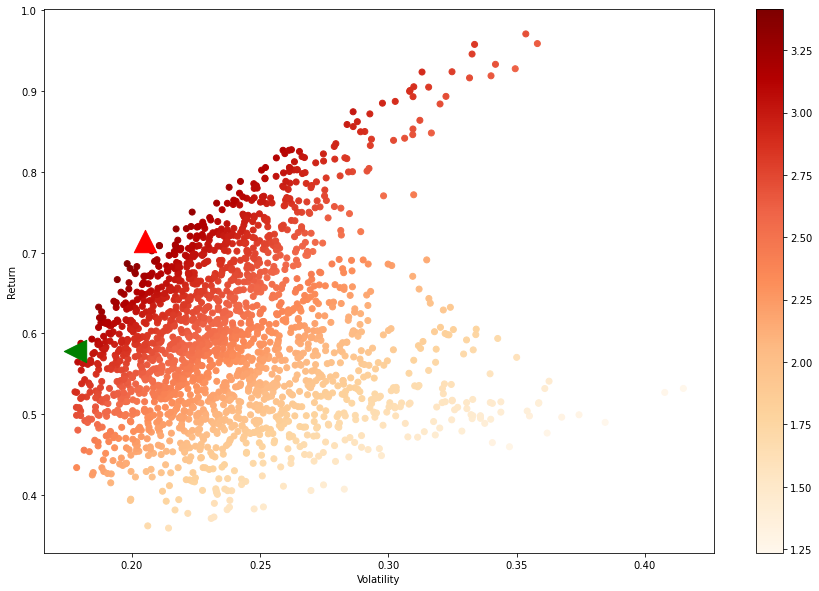

In [30]:
plt.subplots(figsize=(15,10))
#ax = sns.scatterplot(x="Stdev", y="Return", data=pred_output, hue = 'Sharpe', size = 'Sharpe', sizes=(20, 200))

plt.scatter(pred_output.stdev,pred_output['return'],c=pred_output.sharpe,cmap='OrRd')
plt.colorbar()
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.scatter(max_pos.stdev,max_pos['return'],marker='^',color='r',s=500)
plt.scatter(safe_pos.stdev,safe_pos['return'],marker='<',color='g',s=500)

#### Print the portfolio weights for the highest sharpe portfolio and the safest porfolio

In [31]:
print("The highest sharpe porfolio is {} sharpe, at {} volatility".format(max_pos.sharpe.round(3),max_pos.stdev.round(3)))

for i in range(len(port_stock)):
    print("{} : {}%".format(port_stock[i],(max_pos.weight[i] * 100).round(3)))

The highest sharpe porfolio is 3.414 sharpe, at 0.205 volatility
OKE : 26.459%
CMA : 27.664%
PWR : 12.728%
NVDA : 28.994%
NEM : 2.629%
CNP : 1.525%


In [32]:
print("The safest porfolio is {} risk, {} sharpe".format(safe_pos.stdev.round(3), safe_pos.sharpe.round(3)))
for i in range(len(port_stock)):
    print("{} : {}%".format(port_stock[i],(safe_pos.weight[i] * 100).round(3)))

The safest porfolio is 0.178 risk, 3.171 sharpe
OKE : 19.029%
CMA : 44.694%
PWR : 11.17%
NVDA : 13.51%
NEM : 2.252%
CNP : 9.345%
